# Import Required Libraries 

In [1]:
import os
import numpy as np
import pandas as pd
# Pandas Options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize

import json
import requests
import re
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns; sns.set_theme()

%matplotlib inline 

import folium
from folium import plugins
from folium.plugins import HeatMap

from sklearn.cluster import KMeans

print('Libraries Imported.')

Libraries Imported.


# Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
    
1.  <a href="#item1">Introduction / Business Case</a>

2.  <a href="#item2">Data</a>

3.  <a href="#item3">Methodology</a>

3.  <a href="#item3">Analysis</a>

4.  <a href="#item4">Results & Discussion</a>

5.  <a href="#item5">Conclusion</a>  
</font>
</div>                                                           



# 1. Introduction / Business Case <a name="Introduction / Business Case"></a>

Over the course of the last decade food trucks have become increasingly popular across the United States, Including in Arlington County, Virginia a suburb of Washington D.C., where the number of food trucks operating has seemingly increased greatly in recent years. The mobility of food trucks is one of the reasons they are such a popular alternative to brick and mortar restaurants, as they are able to move locations with ease to reach more patrons in different markets. However, as the number of food trucks on the road has greatly increase it has become not too uncommon to see many food trucks crowding a single location, battling over prime real estate. Some popular neighborhoods in downtown Arlington such as Courthouse or Ballston experience this as food trucks gravitate to them. For food trucks location is critical to their success and it is often not easy to branch out and discover new variable location to host their business making known locations more desirable.

This project is aimed towards food truck owners or operators in Arlington County, Virginia in order to explore what features successful neighborhoods for food trucks have and if there are any potential neighborhoods with similar features that would be viable options to explore business in. 

# 2. Data

Base on the business case the project will require data for each Arlington Neighborhood such as:
- Location 
- Nearby Venues 
- Number of Food Trucks Nearby
- Demographics


Data Sources:
- [arlingtonva.us](https://projects.arlingtonva.us/data-research/demographics/neighborhood/) will be utilized to obtain neighborhoods in Alrington, Va as well as there 2010 Census Civic Association Demographics 
- [geopy](https://geopy.readthedocs.io/en/stable/) python library will be used to get the coordinates of each neighborhood
- [fourSquare API](https://developer.foursquare.com/) will be used to collect venue data for each neighborhood, including the number of nearby food trucks 

## 2.1 Neighborhood 2010 Census Data 

The 2010 Civic Association Demographics by Neighborhood for Arlington County, Va can be obtain from [Arlington's Website](https://arlingtonva.us) 

The pdf files from [here](https://projects.arlingtonva.us/data-research/demographics/neighborhood/) have been pre-downloaded and placed in the project directory [\~/data/demographics/pdf/]() then converted to csv and placed [\~/data/demographics/csv/]()

List all csv files in the data directory 

In [2]:
# demographic csv directory path
DIR_PATH = r'data/demographics/csv/'

for i, file in enumerate(os.listdir(DIR_PATH)):
    print(i, "-", file)

0 - Lyon-Park.csv
1 - Madison-Manor.csv
2 - Yorktown.csv
3 - Arlington-View.csv
4 - Boulevard-Manor.csv
5 - Bellevue-Forest.csv
6 - Arlington-Forest.csv
7 - Westover-Village.csv
8 - Columbis-Heights.csv
9 - Ballston-VA-Square.csv
10 - Alcova-Heights.csv
11 - Radnor-FtMyer-Heights.csv
12 - Leeway-Overlee.csv
13 - Forest-Hills.csv
14 - Forest-Glen.csv
15 - Dominion-Hills.csv
16 - Arlingwood.csv
17 - Cherry-Valley-Nature-Area.csv
18 - North-Highlands.csv
19 - Long-Branch-Creek.csv
20 - Foxcroft-Heights.csv
21 - Donaldson-Run.csv
22 - Glencarlyn.csv
23 - Nauck.csv
24 - Claremont.csv
25 - Waycroft-Woodlawn.csv
26 - Arlington-Heights.csv
27 - Old-Dominion.csv
28 - Bluemont.csv
29 - Columbis-Heights-West.csv
30 - Glebewood.csv
31 - Tara-Leeway-Heights.csv
32 - Gulf-Branch.csv
33 - Ashton-Heights.csv
34 - Arlington-Ridge.csv
35 - John-M-Langston.csv
36 - Rivercrest.csv
37 - Fairlington.csv
38 - Penrose.csv
39 - Lyon-Village.csv
40 - Williamsburg.csv
41 - Woodmont.csv
42 - Maywood.csv
43 - Nort

Load the demographic csv files in the data directory and convert them to a pandas data frame 

In [3]:
# Define Function to load and process demographic csv
def process_demographic_csv(file_path):
    # 1. Read csv to pandas df, skip 2 rows, set column 0 as index
    df = pd.read_csv(file_path, skiprows=2, index_col=0)
    # 2. Drop last two columns (Arlington totals)
    df.drop(df.columns[-2:], axis=1, inplace=True)
    # 3. Convert percent column to floats
    df['Percent'] = df['Percent'].str.rstrip('%').astype('float') / 100.0
    # 4. Replace Total rows Percent with Number 
    df['Percent'].mask(df.index.str.contains('TOTAL'), df['Number'], inplace=True)
    # 5. Drop Number column 
    df.drop(columns=['Number'], inplace=True)
    # 6. Rename percent to neighborhood name
    df.columns = [df.index.name]
    df.index.name = None
    # 7. drop na 
    df.dropna(inplace=True)
    # 8. Transpose df
    df = df.T
    
    return df


# load and process all csv files in the data directory 
demographic_dfs = [process_demographic_csv(DIR_PATH+file) for file in os.listdir(DIR_PATH)]

# combine each all of the neighborhoods 
arlington_demographics = pd.concat(demographic_dfs)
# sort data frames index (neighborhood name) alphabetically
arlington_demographics.sort_index(inplace=True)
arlington_demographics

,TOTAL POPULATION,Total Non-Hispanic or Latino,White alone,Black or African-American alone,American Indian or Alaska Native alone,Asian alone,Native Hawaiian or Pacific Islander Alone,Some other Race alone,Two or more Races,Total Hispanic or Latino,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Male,Female,TOTAL HOUSEHOLDS,Family households:,Husband-wife family,Other family:,"Male householder, no wife present","Female householder, no husband present",Nonfamily households:,Householder living alone,Householder not living alone,1-person household,2-person household,3-person household,4-person household,5-person household,6-person household,7-or-more-person household,TOTAL HOUSING UNITS,Occupied Housing Units,Owner-Occupied,Renter-Occupied,Vacant Housing Units
Alcova Heights,"1,900",0.761,0.582,0.047,0.003,0.097,0.000,0.003,0.029,0.239,0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,0.490,0.510,745,0.580,0.474,0.106,0.030,0.077,0.420,0.278,0.142,0.278,0.340,0.168,0.106,0.064,0.019,0.026,784,0.950,0.696,0.254,0.050
Arlington Forest,"2,223",0.927,0.823,0.017,0.001,0.047,0.004,0.001,0.034,0.073,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,0.506,0.494,834,0.685,0.613,0.072,0.018,0.054,0.315,0.207,0.108,0.207,0.317,0.194,0.211,0.049,0.013,0.008,852,0.979,0.823,0.156,0.021
Arlington Heights,"2,555",0.770,0.576,0.060,0.002,0.101,0.003,0.004,0.025,0.230,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,0.499,0.501,"1,032",0.529,0.414,0.115,0.029,0.086,0.471,0.326,0.145,0.326,0.309,0.167,0.102,0.044,0.020,0.033,1070,0.964,0.595,0.369,0.036
Arlington Ridge,"6,324",0.937,0.733,0.040,0.003,0.132,0.001,0.002,0.027,0.063,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,0.479,0.521,"3,549",0.352,0.313,0.039,0.012,0.026,0.648,0.492,0.156,0.492,0.343,0.090,0.051,0.016,0.006,0.002,3755,0.945,0.416,0.529,0.055
Arlington View,979,0.896,0.190,0.619,0.012,0.057,0.001,0.001,0.015,0.104,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,0.487,0.513,376,0.598,0.298,0.301,0.077,0.223,0.402,0.287,0.114,0.287,0.309,0.165,0.122,0.056,0.029,0.032,391,0.962,0.517,0.445,0.038
Arlingwood,366,0.959,0.888,0.019,0.005,0.025,0.000,0.008,0.014,0.041,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,0.478,0.522,136,0.809,0.750,0.059,0.029,0.029,0.191,0.162,0.029,0.162,0.382,0.140,0.243,0.066,0.007,0.000,148,0.919,0.851,0.068,0.081
Ashton Heights,"3,962",0.856,0.685,0.063,0.001,0.082,0.000,0.003,0.022,0.144,0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,0.521,0.479,"1,715",0.451,0.363,0.087,0.027,0.060,0.549,0.362,0.188,0.362,0.304,0.152,0.122,0.036,0.017,0.007,1777,0.965,0.385,0.580,0.035
Aurora Highlands,"8,725",0.907,0.680,0.082,0.003,0.113,0.000,0.001,0.028,0.093,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,0.491,0.509,"4,804",0.297,0.255,0.042,0.012,0.030,0.703,0.507,0.196,0.507,0.326,0.095,0.050,0.014,0.006,0.003,5514,0.871,0.124,0.747,0.129
Ballston - Virginia Square,"13,753",0.948,0.773,0.029,0.001,0.118,0.000,0.002,0.025,0.052,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,0.502,0.498,"8,218",0.240,0.203,0.038,0.014,0.023,0.760,0.514,0.245,0.514,0.363,0.083,0.031,0.007,0.001,0.001,8861,0.927,0.329,0.598,0.073
Barcroft,"3,477",0.632,0.497,0.050,0.002,0.057,0.001,0.003,0.022,0.368,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,0.529,0.471,"1,285",0.602,0.461,0.141,0.068,0.073,0.398,0.267,0.131,0.267,0.282,0.163,0.168,0.065,0.031,0.024,1327,0.968,0.518,0.451,0.032


Drop Race/Ethicity, Sex, Household Subtypes, Household Size Demographics 

In [4]:
# Columns to keep
columns = [
    'TOTAL POPULATION',
    'Under 5 years',
    '5 to 17 years',
    '18 to 24 years',
    '25 to 34 years',
    '35 to 44 years',
    '45 to 54 years',
    '55 to 64 years',
    '65 to 74 years',
    '75 to 84 years',
    '85 years and over',
    'TOTAL HOUSEHOLDS',
    'Family households:',
    'Nonfamily households:',
    'TOTAL HOUSING UNITS',
    'Occupied Housing Units',
    'Vacant Housing Units',
]
arlington_demographics = arlington_demographics[columns].copy()
arlington_demographics

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,Family households:,Nonfamily households:,TOTAL HOUSING UNITS,Occupied Housing Units,Vacant Housing Units
Alcova Heights,"1,900",0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,745,0.580,0.420,784,0.950,0.050
Arlington Forest,"2,223",0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021
Arlington Heights,"2,555",0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,"1,032",0.529,0.471,1070,0.964,0.036
Arlington Ridge,"6,324",0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,"3,549",0.352,0.648,3755,0.945,0.055
Arlington View,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081
Ashton Heights,"3,962",0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,"1,715",0.451,0.549,1777,0.965,0.035
Aurora Highlands,"8,725",0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,"4,804",0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,"13,753",0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,"8,218",0.240,0.760,8861,0.927,0.073
Barcroft,"3,477",0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,"1,285",0.602,0.398,1327,0.968,0.032


Rename Columns

In [5]:
arlington_demographics.rename(columns={"Family households:": "family households", 
                                       "Nonfamily households:": "nonfamily households",
                                       "Nonfamily households:": "nonfamily households",
                                       "Occupied Housing Units": "occupied housing units",
                                       "Vacant Housing Units": "vacant housing units"
                                      }, inplace=True)
arlington_demographics

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units
Alcova Heights,"1,900",0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,745,0.580,0.420,784,0.950,0.050
Arlington Forest,"2,223",0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021
Arlington Heights,"2,555",0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,"1,032",0.529,0.471,1070,0.964,0.036
Arlington Ridge,"6,324",0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,"3,549",0.352,0.648,3755,0.945,0.055
Arlington View,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081
Ashton Heights,"3,962",0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,"1,715",0.451,0.549,1777,0.965,0.035
Aurora Highlands,"8,725",0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,"4,804",0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,"13,753",0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,"8,218",0.240,0.760,8861,0.927,0.073
Barcroft,"3,477",0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,"1,285",0.602,0.398,1327,0.968,0.032


Convert Total Columns from strings to integers

In [6]:
arlington_demographics['TOTAL POPULATION'] = arlington_demographics['TOTAL POPULATION'].str.replace(',', '').astype('int')
arlington_demographics['TOTAL HOUSEHOLDS'] = arlington_demographics['TOTAL HOUSEHOLDS'].str.replace(',', '').astype('int')
arlington_demographics['TOTAL HOUSING UNITS'] = arlington_demographics['TOTAL HOUSING UNITS'].str.replace(',', '').astype('int')
arlington_demographics

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units
Alcova Heights,1900,0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,745,0.580,0.420,784,0.950,0.050
Arlington Forest,2223,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021
Arlington Heights,2555,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,1032,0.529,0.471,1070,0.964,0.036
Arlington Ridge,6324,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,3549,0.352,0.648,3755,0.945,0.055
Arlington View,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081
Ashton Heights,3962,0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,1715,0.451,0.549,1777,0.965,0.035
Aurora Highlands,8725,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,4804,0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,13753,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,8218,0.240,0.760,8861,0.927,0.073
Barcroft,3477,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,1285,0.602,0.398,1327,0.968,0.032


### - Explore Demographic Data

In [7]:
# # Plot the population for each Neighborhood

# x = list(arlington_demographics.index)
# population_df = arlington_demographics[['TOTAL POPULATION']].copy()
# population_df.sort_values('TOTAL POPULATION', ascending=False, inplace=True)
# population=population_df['TOTAL POPULATION']

# # x = list(arlington_demographics.index)
# fig, ax = plt.subplots(figsize=(10,30))

# rects = ax.barh(population_df.index, population, color='orange')

# ax.invert_yaxis()
# ax.set_title("Population by Neighborhood", fontsize=20)
# ax.set_ylabel("Arlington Neighborhood", fontsize=16)
# ax.set_xlabel("Population", fontsize=16)

# for rect in rects:
#     ax.annotate('{}'.format(round(rect.get_width(),2)),
#                 xy=(rect.get_width() + 500, rect.get_y() + rect.get_height()),
#                 xytext=(0, 3),  # 3 points vertical offset
#                 textcoords="offset points",
#                 ha='center', va='bottom')
    
# plt.show()

##  2.2 Arlington Neighborhood Location Data 

Use the geopy python library to obtain coordinates for each neighborhood 

In [8]:
def fetch_location(neigh):
    address = neigh + ', Arlington County, Virginia'
    geolocator = Nominatim(user_agent="my_explorer")
    location = geolocator.geocode(address)
    return location

# Define Columns 
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe 
arlington_neighborhoods_location = pd.DataFrame(columns=column_names)

for i, n in enumerate(arlington_demographics.index):
    if '/' in n or '-' in n:
        s = re.split('/|-', n)
        sum_lat, sum_long, cnt = 0, 0, 0
        # if two or more neighborhoods are combined take the midpoint
        for _n in s:
            location = fetch_location(_n)
            lat, long = (location.latitude, location.longitude) if location else (None, None)
            if(lat and long):
                cnt += 1
                sum_lat += lat
                sum_long += long
        lat, long = sum_lat/cnt if sum_lat != 0 else np.nan , sum_long/cnt if sum_long != 0 else np.nan 

    else:
        location = fetch_location(n)
        lat, long = (location.latitude, location.longitude) if location else (np.nan, np.nan)
        
    arlington_neighborhoods_location.loc[i] = [n, lat, long]
arlington_neighborhoods_location

,Neighborhood,Latitude,Longitude
0,Alcova Heights,38.864557,-77.097201
1,Arlington Forest,38.868856,-77.113084
2,Arlington Heights,38.869557,-77.092201
3,Arlington Ridge,38.890396,-77.084159
4,Arlington View,38.863079,-77.072591
5,Arlingwood,38.927611,-77.121923
6,Ashton Heights,38.894628,-77.077531
7,Aurora Highlands,38.859493,-77.061664
8,Ballston - Virginia Square,38.882475,-77.107412
9,Barcroft,38.855946,-77.103868


neighborhoods geopy failed to find coordinates for 

In [9]:
arlington_neighborhoods_location[arlington_neighborhoods_location.isna().any(axis=1)]

,Neighborhood,Latitude,Longitude
15,Cherry Valley Nature Area,NaN,NaN
36,John M Langston,NaN,NaN
37,Leeway Overlee,NaN,NaN
54,Tara Leeway Heights,NaN,NaN
55,Waverly Hills,NaN,NaN


Manually patching missing or incorrect coordinates using google maps 

In [10]:
location_patches = [
['Arlington Ridge', 38.85357, -77.06798],
['Ashton Heights', 38.87615, -77.10072],
['Aurora Highlands', 38.85420, -77.06106],
['Barcroft', 38.86201, -77.11044],
['Bluemont', 38.87823, -77.12106],
['Boulevard Manor', 38.87007, -77.13587],
['Buckingham', 38.87216, -77.10995],
['Cherrydale', 38.87216, -77.10872],
['Donaldson Run', 38.90617, -77.11617],
['Forest Glen', 38.85914, -77.12141],
['Forest Hills', 38.86952, -77.11799],
['Old Dominion', 38.90011, -77.12456],
['Old Glebe', 38.92017, -77.12938],
['Rock Spring', 38.91049, -77.14109],
['Waverly Hills', 38.89593, -77.11817],
['Williamsburg', 38.90016, -77.15657]]

for l in location_patches:
    arlington_neighborhoods_location.loc[(arlington_neighborhoods_location.Neighborhood == l[0]), ['Latitude', 'Longitude']] = l[1:]
arlington_neighborhoods_location.set_index('Neighborhood', inplace=True)
arlington_neighborhoods_location

,Latitude,Longitude
Neighborhood,,
Alcova Heights,38.864557,-77.097201
Arlington Forest,38.868856,-77.113084
Arlington Heights,38.869557,-77.092201
Arlington Ridge,38.853570,-77.067980
Arlington View,38.863079,-77.072591
Arlingwood,38.927611,-77.121923
Ashton Heights,38.876150,-77.100720
Aurora Highlands,38.854200,-77.061060
Ballston - Virginia Square,38.882475,-77.107412


Drop all remaining neighborhoods without coordinate data

In [11]:
arlington_neighborhoods_location.dropna(inplace=True)
arlington_neighborhoods_location

,Latitude,Longitude
Neighborhood,,
Alcova Heights,38.864557,-77.097201
Arlington Forest,38.868856,-77.113084
Arlington Heights,38.869557,-77.092201
Arlington Ridge,38.853570,-77.067980
Arlington View,38.863079,-77.072591
Arlingwood,38.927611,-77.121923
Ashton Heights,38.876150,-77.100720
Aurora Highlands,38.854200,-77.061060
Ballston - Virginia Square,38.882475,-77.107412


Get the Coordinates for Arlington County, VA 

In [12]:
# get arlington county lat & long

address = 'Arlington County, Virginia'

geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

Create a map of Arlington with neighborhoods superimposed 

In [13]:
map_arlington = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood in zip(arlington_neighborhoods_location['Latitude'], arlington_neighborhoods_location['Longitude'], arlington_neighborhoods_location.index):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_arlington)
    

map_arlington

## 2.3 Alrington Neighborhood Venue Data from FourSquare

Use the [FourSquare Api](https://developer.foursquare.com/) in order to find venues near each of the neighborhoods as well as nearby food trucks 

Define Credentials & Env for Four Square API

In [14]:
# Four Square Credentials & Env 

CLIENT_ID = os.environ.get("FS_CLIENT_ID")
CLIENT_SECRET = os.environ.get("FS_CLIENT_SECRET")
ACCESS_TOKEN = os.environ.get("FS_ACCESS_TOKEN")

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value 

Function to get nearby venues 

In [15]:
# Function to get Near By Venues 
def getNearbyVenues(names, latitudes, longitudes, radius=400):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        
        # API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # GET
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        print(name, "- Venues Found: ", len(results))
        
        # return list of relevant info for each venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    return venues_list

Get List of nearby venues for each neighborhood and create and data frame of all venues 

In [16]:
# Get Venues with radius=500 of Neighborhoods
arlington_venues_list = getNearbyVenues(names=arlington_neighborhoods_location.index, 
                                   latitudes=arlington_neighborhoods_location['Latitude'], 
                                   longitudes=arlington_neighborhoods_location['Longitude'])

arlington_neighborhood_venues = pd.DataFrame([item for venue_list in arlington_venues_list for item in venue_list])
arlington_neighborhood_venues.columns = ['Neighborhood', 
                            'Neighborhood_Latitude', 
                            'Neighborhood_Longitude',
                            'Venue', 
                            'Venue_Latitude', 
                            'Venue_Longitude', 
                            'Venue_Category']

Alcova Heights - Venues Found:  0
Arlington Forest - Venues Found:  7
Arlington Heights - Venues Found:  6
Arlington Ridge - Venues Found:  4
Arlington View - Venues Found:  1
Arlingwood - Venues Found:  2
Ashton Heights - Venues Found:  0
Aurora Highlands - Venues Found:  4
Ballston - Virginia Square - Venues Found:  46
Barcroft - Venues Found:  2
Bellevue Forest - Venues Found:  2
Bluemont - Venues Found:  12
Boulevard Manor - Venues Found:  4
Buckingham - Venues Found:  4
Chain Bridge Forest - Venues Found:  2
Cherrydale - Venues Found:  10
Claremont - Venues Found:  12
Clarendon-Courthouse - Venues Found:  45
Colonial Village - Venues Found:  38
Columbia Forest - Venues Found:  18
Columbia Heights - Venues Found:  3
Columbia Heights West - Venues Found:  3
Dominion Hills - Venues Found:  12
Donaldson Run - Venues Found:  0
Douglas Park - Venues Found:  2
Dover Crystal - Venues Found:  0
East Falls Church - Venues Found:  5
Fairlington - Venues Found:  6
Forest Glen - Venues Found: 

In [17]:
arlington_neighborhood_venues

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Arlington Forest,38.868856,-77.113084,Crystal Thai,38.867608,-77.117250,Thai Restaurant
1,Arlington Forest,38.868856,-77.113084,Subway,38.867888,-77.116996,Sandwich Place
2,Arlington Forest,38.868856,-77.113084,Arlington Forest Shopping Center,38.867699,-77.117069,Shopping Mall
3,Arlington Forest,38.868856,-77.113084,Bricks Pizza,38.867880,-77.117216,Pizza Place
4,Arlington Forest,38.868856,-77.113084,Sense of Place Café,38.867880,-77.117216,Café
5,Arlington Forest,38.868856,-77.113084,Fiesta Oriental Market,38.867671,-77.117141,Grocery Store
6,Arlington Forest,38.868856,-77.113084,Henry Wright Park,38.871618,-77.110371,Park
7,Arlington Heights,38.869557,-77.092201,Thomas Jefferson Community Center & Theatre,38.869751,-77.095811,School
8,Arlington Heights,38.869557,-77.092201,Dominion Apartments,38.867985,-77.095767,Residential Building (Apartment / Condo)
9,Arlington Heights,38.869557,-77.092201,Thomas Jefferson Soccer Field,38.869282,-77.096329,Soccer Field


In [18]:
arlington_neighborhood_venues.shape

(508, 7)

In [19]:
print('There are {} uniques categories and {} unique Venues.'.format(len(arlington_neighborhood_venues['Venue_Category'].unique()), len(arlington_neighborhood_venues['Venue'].unique())))

There are 157 uniques categories and 416 unique Venues.


* Note there are 541 venues in the data frame but only 453 unique venues because due to the proximity of neighborhoods venues can belong to more than one neighborhood

In [20]:
arlington_neighborhood_venues['Venue_Category'].value_counts()

Park                                        32
Pizza Place                                 17
Coffee Shop                                 16
Sandwich Place                              14
Trail                                       13
Convenience Store                           13
Food Truck                                  12
Café                                        11
Mexican Restaurant                          11
Bank                                        11
Gym                                         10
Grocery Store                               10
Pharmacy                                    10
Gym / Fitness Center                        10
Pool                                         9
Bar                                          9
Hotel                                        8
Middle Eastern Restaurant                    8
Chinese Restaurant                           7
Playground                                   7
American Restaurant                          7
Sporting Good

#### Get Data Frame of food truck venues by neighborhood 

In [21]:
# Get Date Frame Of Food Trucks From Venues

arlington_neighborhood_food_trucks = arlington_neighborhood_venues[arlington_neighborhood_venues['Venue_Category'] == 'Food Truck']
arlington_neighborhood_food_trucks

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
53,Ballston - Virginia Square,38.882475,-77.107412,Willie's Po' Boy Truck,38.881614,-77.111602,Food Truck
173,Colonial Village,38.892392,-77.080983,"Tacos ""El Chilango""",38.890531,-77.077326,Food Truck
179,Colonial Village,38.892392,-77.080983,La Tingeria,38.891447,-77.084740,Food Truck
188,Colonial Village,38.892392,-77.080983,Chef On Wheels,38.891131,-77.083711,Food Truck
191,Colonial Village,38.892392,-77.080983,Tacos Matadores,38.891355,-77.084813,Food Truck
198,Colonial Village,38.892392,-77.080983,DC Sliders Truck,38.891121,-77.083576,Food Truck
200,Colonial Village,38.892392,-77.080983,Red Hook Lobster Pound,38.891478,-77.085015,Food Truck
244,Fairlington,38.832971,-77.090225,Pepe Food Truck [José Andrés],38.834806,-77.086521,Food Truck
312,Long Branch Creek,38.849831,-77.074681,Rocklands BBQ Food Truck,38.849620,-77.074201,Food Truck
336,Lyon Park,38.880436,-77.089853,K-BBQ Taco Box FoodTruck By Chef.Eric,38.882149,-77.085954,Food Truck


In [22]:
arlington_neighborhood_food_trucks.shape

(12, 7)

Drop Food Truck Venues from the overall Venue Data Frame 

In [23]:
# Drop Food Trucks from Neighborhood Venues 
arlington_neighborhood_venues.drop(arlington_neighborhood_venues[arlington_neighborhood_venues['Venue_Category'] == 'Food Truck'].index, inplace=True)

#### Generalized Venue Categories 

Since there are 167 venue categories and only 453 venues many of the venue categories only have one or two occurances across all the neighborhoods, therefore we will want to generalize the venue categories in order better group the venues types. The general venue categories will be taken from Four Square [documentation](https://developer.foursquare.com/docs/build-with-foursquare/categories/)

Scrape General Venue Categories from Four Square Developer Docs 

In [24]:
URL = r'https://developer.foursquare.com/docs/build-with-foursquare/categories/'


page = requests.get(URL)
soup = BeautifulSoup(page.text, 'html.parser')

def get_sub_categories(foobar):
    sub_list = foobar.find('ul',  {'class': 'VenueCategories__Wrapper-sc-1ysxg0y-0 dikXMT'})
    sub_categories = [sub.find('h3').text for sub in sub_list.findAll('li', recursive=True)]
    return sub_categories

ul = soup.find('ul',  {'class': 'VenueCategories__Wrapper-sc-1ysxg0y-0 dikXMT'})
general_categories = ul.findAll('li', recursive=False)
general_venue_categories = {gen.find('h3').text: get_sub_categories(gen) for gen in general_categories}

general_venue_categories

{'Arts & Entertainment': ['Amphitheater',
  'Aquarium',
  'Arcade',
  'Art Gallery',
  'Bowling Alley',
  'Casino',
  'Circus',
  'Comedy Club',
  'Concert Hall',
  'Country Dance Club',
  'Disc Golf',
  'Exhibit',
  'General Entertainment',
  'Go Kart Track',
  'Historic Site',
  'Karaoke Box',
  'Laser Tag',
  'Memorial Site',
  'Mini Golf',
  'Movie Theater',
  'Drive-in Theater',
  'Indie Movie Theater',
  'Multiplex',
  'Museum',
  'Art Museum',
  'Erotic Museum',
  'History Museum',
  'Planetarium',
  'Science Museum',
  'Music Venue',
  'Jazz Club',
  'Piano Bar',
  'Rock Club',
  'Pachinko Parlor',
  'Performing Arts Venue',
  'Dance Studio',
  'Indie Theater',
  'Opera House',
  'Theater',
  'Pool Hall',
  'Public Art',
  'Outdoor Sculpture',
  'Street Art',
  'Racecourse',
  'Racetrack',
  'Roller Rink',
  'Salsa Club',
  'Samba School',
  'Stadium',
  'Baseball Stadium',
  'Basketball Stadium',
  'Cricket Ground',
  'Football Stadium',
  'Hockey Arena',
  'Rugby Stadium',
  

Replace Venue Categories in Data Frame with the General Venue Categories

In [25]:
# Get Generalized Venue Categories 

def get_general_venue_category(category):
    for k, i in general_venue_categories.items():
        if category in i: return k
    return "Misc"

for i, row in arlington_neighborhood_venues.iterrows():
    new_category = get_general_venue_category(row['Venue_Category'])
#     print(row['Venue_Category'], '-->', new_category)
    arlington_neighborhood_venues.loc[i, 'Venue_Category'] = get_general_venue_category(row['Venue_Category'])

arlington_neighborhood_venues['Venue_Category'].value_counts()

Food                           201
Shop & Service                 139
Outdoors & Recreation          104
Nightlife Spot                  21
Travel & Transport              14
Arts & Entertainment             8
Professional & Other Places      4
Residence                        3
Misc                             2
Name: Venue_Category, dtype: int64

Drop the Misc Venue Categories 

In [26]:
# Drop All Misc 
arlington_neighborhood_venues.drop(arlington_neighborhood_venues[arlington_neighborhood_venues['Venue_Category'] == 'Misc'].index, inplace=True)
arlington_neighborhood_venues['Venue_Category'].value_counts()

Food                           201
Shop & Service                 139
Outdoors & Recreation          104
Nightlife Spot                  21
Travel & Transport              14
Arts & Entertainment             8
Professional & Other Places      4
Residence                        3
Name: Venue_Category, dtype: int64

In [27]:
arlington_neighborhood_venues

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Arlington Forest,38.868856,-77.113084,Crystal Thai,38.867608,-77.117250,Food
1,Arlington Forest,38.868856,-77.113084,Subway,38.867888,-77.116996,Food
2,Arlington Forest,38.868856,-77.113084,Arlington Forest Shopping Center,38.867699,-77.117069,Shop & Service
3,Arlington Forest,38.868856,-77.113084,Bricks Pizza,38.867880,-77.117216,Food
4,Arlington Forest,38.868856,-77.113084,Sense of Place Café,38.867880,-77.117216,Food
5,Arlington Forest,38.868856,-77.113084,Fiesta Oriental Market,38.867671,-77.117141,Shop & Service
6,Arlington Forest,38.868856,-77.113084,Henry Wright Park,38.871618,-77.110371,Outdoors & Recreation
7,Arlington Heights,38.869557,-77.092201,Thomas Jefferson Community Center & Theatre,38.869751,-77.095811,Professional & Other Places
8,Arlington Heights,38.869557,-77.092201,Dominion Apartments,38.867985,-77.095767,Residence
9,Arlington Heights,38.869557,-77.092201,Thomas Jefferson Soccer Field,38.869282,-77.096329,Outdoors & Recreation


Map of Arlington with venues by category 

In [28]:
map_venues_by_category = folium.Map(location=[latitude, longitude], zoom_start=12)

categories = list(general_venue_categories.keys())
x = np.arange(len(categories))
ys = [i + x + (i*x)**2 for i in range(len(categories))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = {x: colors.rgb2hex(i) for x, i in zip(categories, colors_array)}

for neigh, lat, lng, venue, cate in zip(arlington_neighborhood_venues['Neighborhood'], arlington_neighborhood_venues['Venue_Latitude'], arlington_neighborhood_venues['Venue_Longitude'],arlington_neighborhood_venues['Venue'], arlington_neighborhood_venues['Venue_Category']):
    label = folium.Popup(str(cate), parse_html=True)
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        popup=label, 
        color=rainbow[cate], 
        fill=True, 
        fill_color=rainbow[cate], 
        fill_opacity=0.7).add_to(map_venues_by_category)

map_venues_by_category

#### Get the Frequency of Each Venue Category by Neighborhood

One Hot Encode Venue Data

In [29]:
# one hot encoding 
arlington_neighborhood_venues_onehot = pd.get_dummies(arlington_neighborhood_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
arlington_neighborhood_venues_onehot['Neighborhood'] = arlington_neighborhood_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [arlington_neighborhood_venues_onehot.columns[-1]] + list(arlington_neighborhood_venues_onehot.columns[:-1])
arlington_neighborhood_venues_onehot = arlington_neighborhood_venues_onehot[fixed_columns]

arlington_neighborhood_venues_onehot

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Arlington Forest,0,1,0,0,0,0,0,0
1,Arlington Forest,0,1,0,0,0,0,0,0
2,Arlington Forest,0,0,0,0,0,0,1,0
3,Arlington Forest,0,1,0,0,0,0,0,0
4,Arlington Forest,0,1,0,0,0,0,0,0
5,Arlington Forest,0,0,0,0,0,0,1,0
6,Arlington Forest,0,0,0,1,0,0,0,0
7,Arlington Heights,0,0,0,0,1,0,0,0
8,Arlington Heights,0,0,0,0,0,1,0,0
9,Arlington Heights,0,0,0,1,0,0,0,0


Get Frequency from the one hot encoding

In [30]:
arlington_neighborhood_venues_freq = arlington_neighborhood_venues_onehot.groupby('Neighborhood').mean().reset_index()
arlington_neighborhood_venues_freq

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Arlington Forest,0.000000,0.571429,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000
1,Arlington Heights,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.000000,0.000000
2,Arlington Ridge,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000
3,Arlington View,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
4,Arlingwood,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
5,Aurora Highlands,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000
6,Ballston - Virginia Square,0.000000,0.545455,0.068182,0.068182,0.000000,0.022727,0.227273,0.068182
7,Barcroft,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000
8,Bellevue Forest,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000
9,Bluemont,0.000000,0.583333,0.000000,0.166667,0.000000,0.000000,0.250000,0.000000


Frequency of Venue Categories in each Neighborhood

In [31]:

# for hood in arlington_neighborhood_venues_freq['Neighborhood']:
#     print("-----"+hood+"-----")
#     temp = arlington_neighborhood_venues_freq[arlington_neighborhood_venues_freq['Neighborhood'] == hood].T.reset_index()
#     temp.columns = ['venue', 'freq']
#     temp = temp.iloc[1:]
#     temp['freq'] = temp['freq'].astype(float)
#     temp = temp.round({'freq': 2})
#     print(temp.sort_values('freq', ascending=False).reset_index(drop=True))
#     print('\n') 

In [32]:
arlington_neighborhood_venues_freq.set_index('Neighborhood', inplace=True)
arlington_neighborhood_venues_freq

,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Neighborhood,,,,,,,,
Arlington Forest,0.000000,0.571429,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000
Arlington Heights,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.000000,0.000000
Arlington Ridge,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000
Arlington View,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Arlingwood,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
Aurora Highlands,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000
Ballston - Virginia Square,0.000000,0.545455,0.068182,0.068182,0.000000,0.022727,0.227273,0.068182
Barcroft,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000
Bellevue Forest,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000


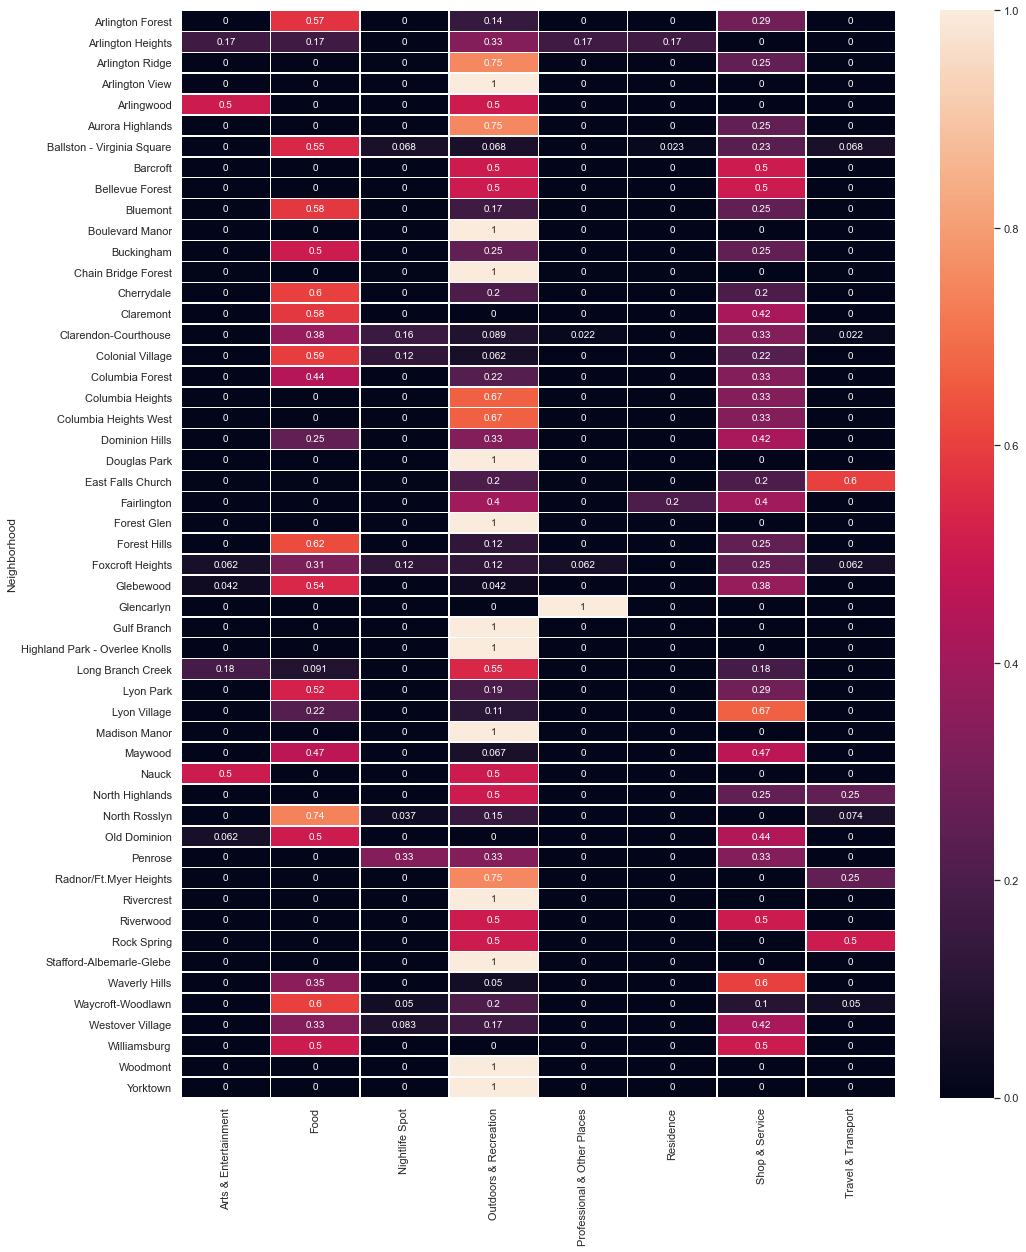

In [33]:
fig, ax = plt.subplots(figsize=(16, 20))
sns.heatmap(ax=ax, data=arlington_neighborhood_venues_freq, annot=True, linewidths=.5, square=False)
plt.show()

In [34]:
arlington_neighborhood_food_truck_count = arlington_neighborhood_food_trucks.groupby('Neighborhood').agg({'Venue':'count'}).rename(columns={'Venue':'Food Truck Count'})
arlington_neighborhood_food_truck_count

,Food Truck Count
Neighborhood,
Ballston - Virginia Square,1
Colonial Village,6
Fairlington,1
Long Branch Creek,1
Lyon Park,1
Waycroft-Woodlawn,2


## 2.4 Data Overview 

- Arlington Neighborhood Coordinates (arligton_neighborhoods_location)
- Arlington Basic Arlington Demographics by Neighborhood (arlington_demographics)
- Arlington Venues by Neighborhood (arlington_neighborhood_venues)
- Arlington Food Truck Venues (arlington_neighborhood_food_trucks)

#### Combine data into single data frame 

In [35]:
arlington_neighborhoods = pd.concat([arlington_neighborhoods_location, arlington_demographics, arlington_neighborhood_venues_freq], axis=1, join="inner")
arlington_neighborhoods = pd.concat([arlington_neighborhoods, arlington_neighborhood_food_truck_count], axis=1, join="outer")
arlington_neighborhoods.fillna(0, inplace=True)
arlington_neighborhoods

,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlington Forest,38.868856,-77.113084,2223,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021,0.000000,0.571429,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000,0.0
Arlington Heights,38.869557,-77.092201,2555,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,1032,0.529,0.471,1070,0.964,0.036,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.000000,0.000000,0.0
Arlington Ridge,38.853570,-77.067980,6324,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,3549,0.352,0.648,3755,0.945,0.055,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
Arlington View,38.863079,-77.072591,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
Arlingwood,38.927611,-77.121923,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0
Aurora Highlands,38.854200,-77.061060,8725,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,4804,0.297,0.703,5514,0.871,0.129,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
Ballston - Virginia Square,38.882475,-77.107412,13753,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,8218,0.240,0.760,8861,0.927,0.073,0.000000,0.545455,0.068182,0.068182,0.000000,0.022727,0.227273,0.068182,1.0
Barcroft,38.862010,-77.110440,3477,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,1285,0.602,0.398,1327,0.968,0.032,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.0
Bellevue Forest,38.914278,-77.113590,1043,0.051,0.206,0.039,0.035,0.134,0.199,0.189,0.072,0.053,0.021,392,0.796,0.204,402,0.975,0.025,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.0
Bluemont,38.878230,-77.121060,5850,0.067,0.118,0.099,0.257,0.151,0.124,0.102,0.048,0.023,0.011,2300,0.519,0.481,2392,0.962,0.038,0.000000,0.583333,0.000000,0.166667,0.000000,0.000000,0.250000,0.000000,0.0


In [36]:
arlington_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, Arlington Forest to Yorktown
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Latitude                     52 non-null     float64
 1   Longitude                    52 non-null     float64
 2   TOTAL POPULATION             52 non-null     int64  
 3   Under 5 years                52 non-null     float64
 4   5 to 17 years                52 non-null     float64
 5   18 to 24 years               52 non-null     float64
 6   25 to 34 years               52 non-null     float64
 7   35 to 44 years               52 non-null     float64
 8   45 to 54 years               52 non-null     float64
 9   55 to 64 years               52 non-null     float64
 10  65 to 74 years               52 non-null     float64
 11  75 to 84 years               52 non-null     float64
 12  85 years and over            52 non-null     float64
 13  TOTAL 

In [37]:
arlington_neighborhoods.describe()

,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,38.881157,-77.109100,3470.442308,0.061827,0.129692,0.078173,0.208077,0.154462,0.136808,0.117077,0.061538,0.033442,0.018865,1640.653846,0.554404,0.445596,1750.442308,0.950519,0.049481,0.029138,0.211981,0.018797,0.454901,0.024065,0.007488,0.217534,0.036096,0.230769
std,0.022744,0.023960,3035.469970,0.016733,0.058961,0.032628,0.126282,0.021879,0.028505,0.037262,0.029240,0.023106,0.016374,1714.077021,0.188824,0.188824,1863.413412,0.024867,0.024867,0.101579,0.255711,0.056647,0.364919,0.140172,0.035804,0.195703,0.115833,0.899137
min,38.832971,-77.156824,309.000000,0.026000,0.025000,0.026000,0.028000,0.101000,0.082000,0.055000,0.018000,0.006000,0.000000,121.000000,0.215000,0.143000,127.000000,0.871000,0.016000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.862812,-77.121538,1101.500000,0.050250,0.088500,0.049000,0.106750,0.142000,0.120000,0.088750,0.041000,0.016750,0.008750,433.500000,0.386500,0.274500,450.750000,0.940750,0.032750,0.000000,0.000000,0.000000,0.138393,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.881455,-77.111291,2562.500000,0.065000,0.132000,0.076000,0.212000,0.156000,0.138500,0.112500,0.056500,0.027000,0.015000,1064.500000,0.562500,0.437500,1110.000000,0.958000,0.042000,0.000000,0.000000,0.000000,0.366667,0.000000,0.000000,0.250000,0.000000,0.000000
75%,38.897515,-77.091289,4888.000000,0.074000,0.186500,0.100500,0.292250,0.169750,0.154250,0.137250,0.072000,0.044250,0.022000,2290.250000,0.725500,0.613500,2393.500000,0.967250,0.059250,0.000000,0.500000,0.000000,0.750000,0.000000,0.000000,0.343750,0.000000,0.000000
max,38.930289,-77.061060,13753.000000,0.101000,0.222000,0.158000,0.477000,0.199000,0.199000,0.220000,0.181000,0.123000,0.085000,8218.000000,0.857000,0.785000,8861.000000,0.984000,0.129000,0.500000,0.740741,0.333333,1.000000,1.000000,0.200000,0.666667,0.600000,6.000000


## 3. Methodology 

The main effort of this project is to identify new neighborhoods to operate food trucks.  In order to discover these new neighborhoods we will identify neighborhoods with a large number of food trucks and find other neighborhoods with similar features without any food trucks yet.  This will be accomplished but clustering the neighborhoods base on a set of features and indentifying the cluster where most of the food trucks are already.  This should provide insight on what neighborhood features make for a successful food truck location.

1) Take the neighborhood data we collected and clean it.
2) 
3) Identify the correct number of clusters
4) run the kmean algo
5) explore the resulting clusters and identify the cluster where the majority of food trucks are
6) indentify possible neighborhoods from the cluster ...

## 4. Analysis

#### prepare data for clustering 

scale data

In [38]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
arlington_neighborhoods_scaled = arlington_neighborhoods.copy()
arlington_neighborhoods_scaled[['TOTAL POPULATION', 'TOTAL HOUSEHOLDS', 'TOTAL HOUSING UNITS']] = min_max_scaler.fit_transform(arlington_neighborhoods_scaled[['TOTAL POPULATION', 'TOTAL HOUSEHOLDS', 'TOTAL HOUSING UNITS']])

arlington_neighborhoods_scaled

,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlington Forest,38.868856,-77.113084,0.142368,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,0.088057,0.685,0.315,0.083009,0.979,0.021,0.000000,0.571429,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000,0.0
Arlington Heights,38.869557,-77.092201,0.167063,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,0.112511,0.529,0.471,0.107969,0.964,0.036,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.000000,0.000000,0.0
Arlington Ridge,38.853570,-77.067980,0.447411,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,0.423367,0.352,0.648,0.415388,0.945,0.055,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
Arlington View,38.863079,-77.072591,0.049836,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,0.031493,0.598,0.402,0.030227,0.962,0.038,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
Arlingwood,38.927611,-77.121923,0.004240,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,0.001853,0.809,0.191,0.002404,0.919,0.081,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0
Aurora Highlands,38.854200,-77.061060,0.626004,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,0.578362,0.297,0.703,0.616785,0.871,0.129,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
Ballston - Virginia Square,38.882475,-77.107412,1.000000,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,1.000000,0.240,0.760,1.000000,0.927,0.073,0.000000,0.545455,0.068182,0.068182,0.000000,0.022727,0.227273,0.068182,1.0
Barcroft,38.862010,-77.110440,0.235644,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,0.143757,0.602,0.398,0.137394,0.968,0.032,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.0
Bellevue Forest,38.914278,-77.113590,0.054597,0.051,0.206,0.039,0.035,0.134,0.199,0.189,0.072,0.053,0.021,0.033469,0.796,0.204,0.031486,0.975,0.025,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.0
Bluemont,38.878230,-77.121060,0.412154,0.067,0.118,0.099,0.257,0.151,0.124,0.102,0.048,0.023,0.011,0.269112,0.519,0.481,0.259331,0.962,0.038,0.000000,0.583333,0.000000,0.166667,0.000000,0.000000,0.250000,0.000000,0.0


Drop neighborhood location & food truck count

In [39]:
arlington_neighborhoods_clustering = arlington_neighborhoods_scaled.reset_index(drop=True)
arlington_neighborhoods_clustering.drop(columns=['Latitude', 'Longitude', 'Food Truck Count'], inplace=True)
arlington_neighborhoods_clustering

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.142368,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,0.088057,0.685,0.315,0.083009,0.979,0.021,0.000000,0.571429,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000
1,0.167063,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,0.112511,0.529,0.471,0.107969,0.964,0.036,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.000000,0.000000
2,0.447411,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,0.423367,0.352,0.648,0.415388,0.945,0.055,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000
3,0.049836,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,0.031493,0.598,0.402,0.030227,0.962,0.038,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
4,0.004240,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,0.001853,0.809,0.191,0.002404,0.919,0.081,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
5,0.626004,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,0.578362,0.297,0.703,0.616785,0.871,0.129,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000
6,1.000000,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,1.000000,0.240,0.760,1.000000,0.927,0.073,0.000000,0.545455,0.068182,0.068182,0.000000,0.022727,0.227273,0.068182
7,0.235644,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,0.143757,0.602,0.398,0.137394,0.968,0.032,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000
8,0.054597,0.051,0.206,0.039,0.035,0.134,0.199,0.189,0.072,0.053,0.021,0.033469,0.796,0.204,0.031486,0.975,0.025,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000
9,0.412154,0.067,0.118,0.099,0.257,0.151,0.124,0.102,0.048,0.023,0.011,0.269112,0.519,0.481,0.259331,0.962,0.038,0.000000,0.583333,0.000000,0.166667,0.000000,0.000000,0.250000,0.000000


### Clustering 

Select the correct number of clusters

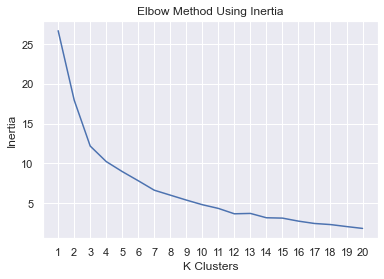

In [40]:
max_clusters = 20

inertias = []
for k in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(arlington_neighborhoods_clustering)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, max_clusters+1), inertias)
plt.title("Elbow Method Using Inertia")
plt.ylabel("Inertia")
plt.xlabel("K Clusters")
plt.xticks(ticks=range(1, max_clusters+1))
plt.show()

Base on the elbow method 4 clusters is determined to be the optimal ammount 

### Kmeans Clustering 

- n_clusters = 6
- n_init = 10
- random_state = 0

In [41]:
kclusters = 6
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=10).fit(arlington_neighborhoods_clustering)

Add cluster Labels to Arlington Neighborhood Data

In [42]:
arlington_neighborhoods_clusters = arlington_neighborhoods.copy()
arlington_neighborhoods_clusters.insert(0, 'Cluster Labels', kmeans.labels_)
arlington_neighborhoods_clusters

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlington Forest,0,38.868856,-77.113084,2223,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021,0.000000,0.571429,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000,0.0
Arlington Heights,0,38.869557,-77.092201,2555,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,1032,0.529,0.471,1070,0.964,0.036,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.000000,0.000000,0.0
Arlington Ridge,1,38.853570,-77.067980,6324,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,3549,0.352,0.648,3755,0.945,0.055,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
Arlington View,3,38.863079,-77.072591,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
Arlingwood,5,38.927611,-77.121923,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0
Aurora Highlands,1,38.854200,-77.061060,8725,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,4804,0.297,0.703,5514,0.871,0.129,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
Ballston - Virginia Square,2,38.882475,-77.107412,13753,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,8218,0.240,0.760,8861,0.927,0.073,0.000000,0.545455,0.068182,0.068182,0.000000,0.022727,0.227273,0.068182,1.0
Barcroft,5,38.862010,-77.110440,3477,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,1285,0.602,0.398,1327,0.968,0.032,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.0
Bellevue Forest,5,38.914278,-77.113590,1043,0.051,0.206,0.039,0.035,0.134,0.199,0.189,0.072,0.053,0.021,392,0.796,0.204,402,0.975,0.025,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.0
Bluemont,4,38.878230,-77.121060,5850,0.067,0.118,0.099,0.257,0.151,0.124,0.102,0.048,0.023,0.011,2300,0.519,0.481,2392,0.962,0.038,0.000000,0.583333,0.000000,0.166667,0.000000,0.000000,0.250000,0.000000,0.0


Create a map of Arlington with clusters superimposed

In [43]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for neigh, lat, lng, cluster in zip(arlington_neighborhoods_clusters.index, arlington_neighborhoods_clusters['Latitude'], arlington_neighborhoods_clusters['Longitude'], arlington_neighborhoods_clusters['Cluster Labels']):
    label = folium.Popup(str(neigh) + ' Cluster ' + str(int(cluster)+1), parse_html=True)
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        popup=label, 
        color=rainbow[int(cluster)-1], 
        fill=True, 
        fill_color=rainbow[int(cluster)-1], 
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### Explore the Clusters 

In [44]:
clusters = []
for cluster in range(kclusters):
    clusters.append(arlington_neighborhoods_clusters[arlington_neighborhoods_clusters['Cluster Labels'] == cluster])

#### Cluster 0

In [45]:
clusters[0]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlington Forest,0,38.868856,-77.113084,2223,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021,0.000000,0.571429,0.000000,0.142857,0.000000,0.000000,0.285714,0.0000,0.0
Arlington Heights,0,38.869557,-77.092201,2555,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,1032,0.529,0.471,1070,0.964,0.036,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.000000,0.0000,0.0
Cherrydale,0,38.872160,-77.108720,3169,0.068,0.138,0.075,0.157,0.157,0.135,0.125,0.074,0.045,0.026,1178,0.570,0.430,1225,0.962,0.038,0.000000,0.600000,0.000000,0.200000,0.000000,0.000000,0.200000,0.0000,0.0
Claremont,0,38.843168,-77.104701,2008,0.080,0.124,0.076,0.198,0.165,0.152,0.118,0.047,0.027,0.013,746,0.615,0.385,769,0.970,0.030,0.000000,0.583333,0.000000,0.000000,0.000000,0.000000,0.416667,0.0000,0.0
Columbia Forest,0,38.854001,-77.110257,3793,0.074,0.109,0.106,0.252,0.173,0.129,0.089,0.041,0.017,0.009,1603,0.518,0.482,1776,0.903,0.097,0.000000,0.444444,0.000000,0.222222,0.000000,0.000000,0.333333,0.0000,0.0
Forest Hills,0,38.869520,-77.117990,309,0.045,0.068,0.032,0.074,0.113,0.126,0.220,0.181,0.123,0.016,158,0.563,0.437,167,0.946,0.054,0.000000,0.625000,0.000000,0.125000,0.000000,0.000000,0.250000,0.0000,0.0
Foxcroft Heights,0,38.868695,-77.070793,357,0.076,0.132,0.112,0.255,0.151,0.120,0.101,0.045,0.008,0.000,121,0.488,0.512,127,0.953,0.047,0.062500,0.312500,0.125000,0.125000,0.062500,0.000000,0.250000,0.0625,0.0
Glebewood,0,38.897955,-77.124437,840,0.062,0.090,0.080,0.220,0.144,0.135,0.101,0.060,0.049,0.060,370,0.457,0.543,385,0.961,0.039,0.041667,0.541667,0.000000,0.041667,0.000000,0.000000,0.375000,0.0000,0.0
Glencarlyn,0,38.861779,-77.129146,1841,0.048,0.115,0.049,0.103,0.106,0.142,0.154,0.131,0.096,0.055,731,0.560,0.440,760,0.962,0.038,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0000,0.0
Lyon Village,0,38.892982,-77.096535,3531,0.060,0.105,0.082,0.299,0.158,0.121,0.098,0.047,0.018,0.012,1587,0.451,0.549,1665,0.953,0.047,0.000000,0.222222,0.000000,0.111111,0.000000,0.000000,0.666667,0.0000,0.0


#### Cluster 1

In [46]:
clusters[1]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlington Ridge,1,38.853570,-77.067980,6324,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,3549,0.352,0.648,3755,0.945,0.055,0.000000,0.000000,0.000000,0.750000,0.0,0.0,0.250000,0.00,0.0
Aurora Highlands,1,38.854200,-77.061060,8725,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,4804,0.297,0.703,5514,0.871,0.129,0.000000,0.000000,0.000000,0.750000,0.0,0.0,0.250000,0.00,0.0
Columbia Heights,1,38.857612,-77.121090,4985,0.058,0.063,0.098,0.340,0.175,0.120,0.088,0.035,0.018,0.006,2842,0.309,0.691,2994,0.949,0.051,0.000000,0.000000,0.000000,0.666667,0.0,0.0,0.333333,0.00,0.0
Columbia Heights West,1,38.857612,-77.121090,7398,0.087,0.175,0.096,0.211,0.172,0.130,0.077,0.035,0.013,0.004,2551,0.615,0.385,2638,0.967,0.033,0.000000,0.000000,0.000000,0.666667,0.0,0.0,0.333333,0.00,0.0
Douglas Park,1,38.853087,-77.097329,9365,0.068,0.134,0.089,0.246,0.187,0.138,0.081,0.036,0.015,0.006,3689,0.562,0.438,3987,0.925,0.075,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.00,0.0
Fairlington,1,38.832971,-77.090225,8137,0.074,0.058,0.045,0.323,0.199,0.117,0.118,0.045,0.017,0.004,4574,0.376,0.624,4766,0.960,0.040,0.000000,0.000000,0.000000,0.400000,0.0,0.2,0.400000,0.00,1.0
Long Branch Creek,1,38.849831,-77.074681,4024,0.062,0.084,0.113,0.389,0.166,0.098,0.055,0.020,0.009,0.004,2044,0.365,0.635,2313,0.884,0.116,0.181818,0.090909,0.000000,0.545455,0.0,0.0,0.181818,0.00,1.0
Nauck,1,38.847535,-77.087774,5738,0.064,0.132,0.105,0.260,0.151,0.128,0.086,0.039,0.025,0.010,2287,0.520,0.480,2398,0.954,0.046,0.500000,0.000000,0.000000,0.500000,0.0,0.0,0.000000,0.00,0.0
North Highlands,1,38.898167,-77.083033,3032,0.044,0.037,0.138,0.428,0.135,0.086,0.073,0.040,0.014,0.005,1758,0.262,0.738,1852,0.949,0.051,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.250000,0.25,0.0
Penrose,1,38.868594,-77.083077,4780,0.051,0.087,0.090,0.313,0.165,0.129,0.099,0.040,0.019,0.008,2394,0.390,0.610,2694,0.889,0.111,0.000000,0.000000,0.333333,0.333333,0.0,0.0,0.333333,0.00,0.0


#### Cluster 2

In [47]:
clusters[2]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Ballston - Virginia Square,2,38.882475,-77.107412,13753,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,8218,0.240,0.760,8861,0.927,0.073,0.0,0.545455,0.068182,0.068182,0.000000,0.022727,0.227273,0.068182,1.0
Clarendon-Courthouse,2,38.891076,-77.091643,8722,0.043,0.038,0.105,0.477,0.175,0.082,0.055,0.018,0.006,0.002,5081,0.269,0.731,5403,0.940,0.060,0.0,0.377778,0.155556,0.088889,0.022222,0.000000,0.333333,0.022222,0.0
Radnor/Ft.Myer Heights,2,38.883231,-77.076931,11453,0.032,0.034,0.150,0.424,0.146,0.093,0.069,0.035,0.014,0.004,6637,0.254,0.746,7289,0.911,0.089,0.0,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.250000,0.0


#### Cluster 3

In [48]:
clusters[3]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlington View,3,38.863079,-77.072591,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Boulevard Manor,3,38.870070,-77.135870,1828,0.068,0.159,0.068,0.109,0.142,0.135,0.112,0.063,0.058,0.085,678,0.640,0.360,713,0.951,0.049,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Chain Bridge Forest,3,38.930289,-77.112141,528,0.044,0.222,0.044,0.030,0.114,0.155,0.178,0.093,0.085,0.036,194,0.825,0.175,202,0.960,0.040,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Forest Glen,3,38.859140,-77.121410,924,0.044,0.132,0.096,0.213,0.169,0.163,0.100,0.058,0.015,0.009,402,0.448,0.552,420,0.957,0.043,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Gulf Branch,3,38.921157,-77.117225,919,0.063,0.220,0.036,0.048,0.138,0.182,0.178,0.076,0.042,0.016,334,0.796,0.204,349,0.957,0.043,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Highland Park - Overlee Knolls,3,38.887751,-77.147063,1692,0.074,0.191,0.047,0.113,0.176,0.163,0.133,0.068,0.020,0.014,607,0.727,0.273,627,0.968,0.032,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Madison Manor,3,38.880390,-77.147202,1370,0.073,0.186,0.052,0.120,0.172,0.150,0.134,0.053,0.042,0.019,495,0.749,0.251,505,0.980,0.020,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Rivercrest,3,38.922056,-77.119145,344,0.058,0.180,0.026,0.055,0.131,0.195,0.151,0.113,0.038,0.052,126,0.857,0.143,128,0.984,0.016,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Stafford-Albemarle-Glebe,3,38.889404,-77.117144,727,0.045,0.204,0.045,0.028,0.116,0.172,0.173,0.120,0.062,0.036,271,0.841,0.159,282,0.961,0.039,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Woodmont,3,38.900667,-77.094978,883,0.072,0.189,0.048,0.077,0.145,0.180,0.148,0.068,0.040,0.033,303,0.782,0.218,324,0.935,0.065,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [49]:
clusters[4]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Bluemont,4,38.878230,-77.121060,5850,0.067,0.118,0.099,0.257,0.151,0.124,0.102,0.048,0.023,0.011,2300,0.519,0.481,2392,0.962,0.038,0.0,0.583333,0.000000,0.166667,0.0,0.0,0.250000,0.000000,0.0
Buckingham,4,38.872160,-77.109950,5732,0.052,0.095,0.109,0.267,0.142,0.105,0.092,0.059,0.048,0.030,2861,0.320,0.680,3063,0.934,0.066,0.0,0.500000,0.000000,0.250000,0.0,0.0,0.250000,0.000000,0.0
Colonial Village,4,38.892392,-77.080983,2570,0.026,0.030,0.124,0.455,0.162,0.086,0.065,0.036,0.013,0.004,1621,0.215,0.785,1700,0.954,0.046,0.0,0.593750,0.125000,0.062500,0.0,0.0,0.218750,0.000000,6.0
Lyon Park,4,38.880436,-77.089853,4862,0.051,0.089,0.115,0.345,0.154,0.111,0.078,0.037,0.013,0.007,2370,0.368,0.632,2526,0.938,0.062,0.0,0.523810,0.000000,0.190476,0.0,0.0,0.285714,0.000000,1.0
North Rosslyn,4,38.895979,-77.070909,2536,0.028,0.026,0.158,0.377,0.142,0.093,0.086,0.064,0.021,0.006,1442,0.299,0.701,1564,0.922,0.078,0.0,0.740741,0.037037,0.148148,0.0,0.0,0.000000,0.074074,0.0


In [50]:
clusters[5]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlingwood,5,38.927611,-77.121923,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081,0.5,0.00,0.0,0.500000,0.0,0.0,0.000000,0.0,0.0
Barcroft,5,38.862010,-77.110440,3477,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,1285,0.602,0.398,1327,0.968,0.032,0.0,0.00,0.0,0.500000,0.0,0.0,0.500000,0.0,0.0
Bellevue Forest,5,38.914278,-77.113590,1043,0.051,0.206,0.039,0.035,0.134,0.199,0.189,0.072,0.053,0.021,392,0.796,0.204,402,0.975,0.025,0.0,0.00,0.0,0.500000,0.0,0.0,0.500000,0.0,0.0
Dominion Hills,5,38.875945,-77.141091,1695,0.079,0.195,0.049,0.117,0.174,0.162,0.125,0.050,0.027,0.022,599,0.723,0.277,613,0.977,0.023,0.0,0.25,0.0,0.333333,0.0,0.0,0.416667,0.0,0.0
East Falls Church,5,38.885976,-77.156824,4966,0.074,0.159,0.069,0.179,0.156,0.143,0.123,0.056,0.021,0.021,1890,0.641,0.359,1953,0.968,0.032,0.0,0.00,0.0,0.200000,0.0,0.0,0.200000,0.6,0.0
Riverwood,5,38.905389,-77.102479,488,0.078,0.191,0.033,0.043,0.139,0.154,0.176,0.105,0.053,0.029,174,0.787,0.213,185,0.941,0.059,0.0,0.00,0.0,0.500000,0.0,0.0,0.500000,0.0,0.0
Rock Spring,5,38.910490,-77.141090,2850,0.066,0.220,0.045,0.065,0.144,0.175,0.148,0.074,0.045,0.019,996,0.801,0.199,1024,0.973,0.027,0.0,0.00,0.0,0.500000,0.0,0.0,0.000000,0.5,0.0


In [51]:
t = arlington_neighborhoods_clusters.groupby('Cluster Labels').mean().reset_index()
t['Food Truck Count'] = arlington_neighborhoods_clusters[['Cluster Labels', 'Food Truck Count']].groupby('Cluster Labels').sum()
t

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
0,0,38.878909,-77.114008,2111.375000,0.070187,0.130562,0.071563,0.178187,0.159500,0.140000,0.123625,0.069750,0.037313,0.019063,859.687500,0.569812,0.430188,900.125000,0.958750,0.041250,0.020833,0.426079,0.016146,0.111533,0.076823,0.010417,0.331138,0.007031,2.0
1,1,38.857318,-77.088734,6250.800000,0.058800,0.087400,0.096000,0.316100,0.165000,0.116600,0.088600,0.042300,0.020700,0.008600,3049.200000,0.404800,0.595200,3291.100000,0.929300,0.070700,0.068182,0.009091,0.033333,0.611212,0.000000,0.020000,0.233182,0.025000,2.0
2,2,38.885594,-77.091995,11309.333333,0.034000,0.032333,0.131000,0.444667,0.151667,0.085667,0.064667,0.030000,0.015667,0.010667,6645.333333,0.254333,0.745667,7184.333333,0.926000,0.074000,0.000000,0.307744,0.074579,0.302357,0.007407,0.007576,0.186869,0.113468,1.0
3,3,38.893343,-77.120505,1255.454545,0.062091,0.183727,0.054000,0.097545,0.147182,0.162818,0.142091,0.075273,0.044364,0.030636,460.454545,0.729182,0.270818,478.181818,0.962273,0.037727,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,4,38.883839,-77.094551,4310.000000,0.044800,0.071600,0.121000,0.340200,0.150200,0.103800,0.084600,0.048800,0.023600,0.011600,2118.800000,0.344200,0.655800,2249.000000,0.942000,0.058000,0.000000,0.588327,0.032407,0.163558,0.000000,0.000000,0.200893,0.014815,7.0
5,5,38.897386,-77.126777,2126.428571,0.070714,0.186429,0.052571,0.100000,0.143571,0.163000,0.149143,0.071286,0.040286,0.023286,781.714286,0.737000,0.263000,807.428571,0.960143,0.039857,0.071429,0.035714,0.000000,0.433333,0.000000,0.000000,0.302381,0.157143,0.0


In [52]:
arlington_neighborhoods_clusters[['Cluster Labels', 'Food Truck Count']].groupby('Cluster Labels').sum()


,Food Truck Count
Cluster Labels,
0,2.0
1,2.0
2,1.0
3,0.0
4,7.0
5,0.0


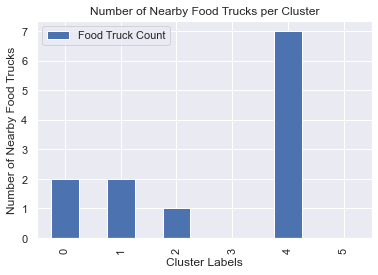

In [53]:
ax = t.plot.bar(x='Cluster Labels', y='Food Truck Count')
ax.set_title("Number of Nearby Food Trucks per Cluster")
ax.set_ylabel("Number of Nearby Food Trucks")
plt.show()

In [54]:
# ax1 = t.plot.scatter(x='Food Truck Count', y='Food', c='blue')
# ax2 = t.plot.scatter(x='Food Truck Count', y='Nightlife Spot', c='green')
# ax2 = t.plot.scatter(x='Food Truck Count', y='Outdoors & Recreation', c='green')
# ax2 = t.plot.scatter(x='Food Truck Count', y='Professional & Other Places', c='green')
# ax2 = t.plot.scatter(x='Food Truck Count', y='Residence', c='green')
# ax2 = t.plot.scatter(x='Food Truck Count', y='Shop & Service', c='green')
# ax2 = t.plot.scatter(x='Food Truck Count', y='Travel & Transport', c='green')
# # ax2 = t.plot(x='Food Truck Count', y=['Food', 'Nightlife Spot'])
# plt.show()

In [55]:
_corr = t.corr()
_corr["Food Truck Count"].sort_values(ascending=False)

Food Truck Count               1.000000
Food                           0.786368
18 to 24 years                 0.593447
nonfamily households           0.552486
Longitude                      0.534875
25 to 34 years                 0.464275
vacant housing units           0.287007
Nightlife Spot                 0.240057
35 to 44 years                 0.171312
Shop & Service                 0.139504
Cluster Labels                 0.081992
TOTAL POPULATION               0.070610
TOTAL HOUSEHOLDS               0.048119
TOTAL HOUSING UNITS            0.045055
Professional & Other Places   -0.018386
Residence                     -0.072032
Latitude                      -0.259887
occupied housing units        -0.287007
Arts & Entertainment          -0.319110
65 to 74 years                -0.328181
Under 5 years                 -0.396664
Travel & Transport            -0.412077
75 to 84 years                -0.434738
55 to 64 years                -0.500555
5 to 17 years                 -0.508636


In [56]:
# explore_clustering = arlington_neighborhoods_clustering.copy()
# explore_clustering.insert(0, 'Cluster Labels', kmeans.labels_)
# explore_clustering = explore_clustering.groupby('Cluster Labels').mean().reset_index()
# explore_clustering.insert(0, 'Food Truck Count', arlington_neighborhoods_clusters[['Cluster Labels', 'Food Truck Count']].groupby('Cluster Labels').sum()['Food Truck Count'])
# explore_clustering

# df_corr = explore_clustering.corr()
# df_corr["Food Truck Count"].sort_values(ascending=False)

#### Identify the Cluster Containing the majority of food trucks 

Cluster 5 contains 6 out of 10 food trucks venues and therefore neighborhoods in this cluster will be possible candidates for new food truck loctions 

Members of cluster 5 without any food trucks 

In [57]:
canidate_cluster = clusters[5]
canidate_cluster[canidate_cluster['Food Truck Count'] == 0]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlingwood,5,38.927611,-77.121923,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081,0.5,0.00,0.0,0.500000,0.0,0.0,0.000000,0.0,0.0
Barcroft,5,38.862010,-77.110440,3477,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,1285,0.602,0.398,1327,0.968,0.032,0.0,0.00,0.0,0.500000,0.0,0.0,0.500000,0.0,0.0
Bellevue Forest,5,38.914278,-77.113590,1043,0.051,0.206,0.039,0.035,0.134,0.199,0.189,0.072,0.053,0.021,392,0.796,0.204,402,0.975,0.025,0.0,0.00,0.0,0.500000,0.0,0.0,0.500000,0.0,0.0
Dominion Hills,5,38.875945,-77.141091,1695,0.079,0.195,0.049,0.117,0.174,0.162,0.125,0.050,0.027,0.022,599,0.723,0.277,613,0.977,0.023,0.0,0.25,0.0,0.333333,0.0,0.0,0.416667,0.0,0.0
East Falls Church,5,38.885976,-77.156824,4966,0.074,0.159,0.069,0.179,0.156,0.143,0.123,0.056,0.021,0.021,1890,0.641,0.359,1953,0.968,0.032,0.0,0.00,0.0,0.200000,0.0,0.0,0.200000,0.6,0.0
Riverwood,5,38.905389,-77.102479,488,0.078,0.191,0.033,0.043,0.139,0.154,0.176,0.105,0.053,0.029,174,0.787,0.213,185,0.941,0.059,0.0,0.00,0.0,0.500000,0.0,0.0,0.500000,0.0,0.0
Rock Spring,5,38.910490,-77.141090,2850,0.066,0.220,0.045,0.065,0.144,0.175,0.148,0.074,0.045,0.019,996,0.801,0.199,1024,0.973,0.027,0.0,0.00,0.0,0.500000,0.0,0.0,0.000000,0.5,0.0


This leaves 5 possible neighborhood to operate a food truck 

## 5. Results & Discussion

According to the Arlington County website there are 61 demographically distinct neighborhoods in Arlington as of the 2010 census.   

However four of the neighborhoods were not consider due to the lack of coordinate locations, Cherry Hill Nature Area, John M Longston, Leeway Overlee, and Tara Leeway Heights

Additionally another two neighborhoods were rules out for having no nearby venues according to Four Square, Ashston Heights and Donaldson Run

Of the remaining 55  neighborhood we analyzed 5 were found to have nearby food truck venues leaving a possible 50 neighborhoods as potential new areas for food trucks.  



The 55 neighborhoods were then clustered based on their nearby venues as well as demographics resulting in 5 distinct clusters of similar neighborhoods.  

Of the 5 clusters found cluster 2 had the majority of the food truck venues nearby, 8 out of the 10 found by Four Square near neighborhoods.
The cluster also contained 19 of the 55 neighborhoods, 3 of which were had nearby food trucks leaving 16 possible candidate neighborhoods.

Upon further examination a correlation can be seen between cluster with a large frequency of Food and Shopping venues, 18-44 year olds, and non family housing.  

## 6. Conclusion